In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
camvid_path = kagglehub.dataset_download('carlolepelaars/camvid')

print('Data source import complete.')

Using Colab cache for faster access to the 'camvid' dataset.
Data source import complete.



# **Programming Assignment 1 - Semantic Segmentation**

#### **Professor**: Dário Oliveira  
#### **Monitor**: Lívia Meinhardt

Neste trabalho prático, vocês irão investigar o desempenho de modelos de segmentação semântica, utilizando redes U-Net e DeepLabV3. A proposta vai além de treinar modelos: vocês deverão analisar onde eles funcionam bem (ou não), interpretar os erros e justificar suas decisões com base nos conceitos vistos em aula.


### **Instruções:**

1. **Escolha do Ambiente de Execução**:  
   Utilize Google Colab ou Kaggle Notebook. Recomendamos iniciar seu notebook no Kaggle diretamente da página do dataset [CamVid](https://www.kaggle.com/datasets/carlolepelaars/camvid).

3. **Criação de um Dataset Customizado**:  
   As máscaras vêm em formato RGB. Use o CSV fornecido para converter as cores em labels (classe por pixel). Crie seu próprio Dataset em PyTorch.

4. **Construção da Arquitetura U-Net**:  
   Implemente uma U-Net (ou ResUNet), com a possibilidade de variar sua profundidade (número de blocos codificadores/decodificadores). Explore como isso impacta o desempenho e a quantidade de parâmetros.

   ![Estrutura U-Net](https://camo.githubusercontent.com/6b548ee09b97874014d72903c891360beb0989e74b4585249436421558faa89d/68747470733a2f2f692e696d6775722e636f6d2f6a6544567071462e706e67)

5. **Função de Treinamento**:  
   Crie uma função de treinamento e registre métricas (loss, acurácia) em cada época. A cada 5 ou 10 épocas, visualize uma predição (imagem original, máscara verdadeira e predita).

6. **Experimentação**:
    Além da profundidade da rede e como ela afeta desempenho e quantidade de parâmetros, explore pelo menos dois otimizadores e funções de perda adequadas para segmentação semântica. Fundamente as escolhas e explique os resultados de acordo com a teoria vista em aula.

8. **Avaliação**:
   Implemente as métricas por classe: Precisão e IoU. Além da média geral, use para identificar as classes com pior desempenho e caracterizar seu melhor modelo.

9. **Explicabilidade com Mapas de Erro**:
   Escolha imagens com desempenho ruim (menor IoU ou precisão) e gere mapas de erro. Analise visualmente onde o modelo erra (bordas, classes confundidas, objetos pequenos, etc.). Relacione os erros às métricas.

10. **Data Augmentation**:  
     Implemente alguma forma de data augmentation. Avalie se houve ganho em desempenho. Justifique.

11. **Fine-Tuning do DeepLabV3**:
   Realize o fine-tuning do modelo [DeepLabV3](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.segmentation.deeplabv3_resnet50.html#torchvision.models.segmentation.deeplabv3_resnet50) pré-treinado ajustando `classifier` e `aux_classifier` para o número de classes do seu dataset. Congele o backbone conforme necessário e treine o modelo. Compare seu desempenho com a melhor U-Net em termos de métricas, número de parâmetros e qualidade visual das predições.

12. **Apresentação Final**:  
    Ao final, prepare uma apresentação resumindo os passos seguidos, resultados obtidos, gráficos de perdas e acurácia, e discussões sobre o desempenho do modelo. Lembre de fundamentar a discussão com os aspectos teoricos vistos em sala de aula.


### **Pontos Importantes:**

- Escolher adequadamente o tamanho do BATCH, Loss Function e Otimizador e saber o motivo de cada escolha;
- Monitore o uso das GPUs, o kaggle te informa quantidade de tempo disponível, mas o colab não;
- Observe as classes com mais erros por parte do modelo;
- Adicione gráficos de perda e acurácia na sua apresentação;
- Coloque imagens das predições do modelo;
- Use **Pytorch !!!**.

Note que as instruções acima são os requisitos da entrega, mas não precisam ser feitas exatamente nesta ordem. Você pode implementar o lógica de validação do modelo, testar uma versão inicial e modificar conforme os resultados obtidos. Lembre-se de fundamentas suas escolhas e fluxo de trabalho na apresentação.

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import ToTensor, Lambda
from torchvision.io import decode_image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import os
import glob

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
f"using device {device}"

'using device cuda'

In [3]:
#----------------------------I/O no Kaggle------------------------------
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        continue
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
#------------------Dataset para carregar as imagens---------------------
class CamVidDataset(Dataset):

    #inicializa o dataset
    def __init__(self, type_, img_dim = [720, 960], dataset_path = ("/", "kaggle", "input", "camvid"), device = "cpu"):
        #Carrega o caminho do conjunto desejado (val, train, test)
        self.base_path_data = os.path.join(*dataset_path, "CamVid", f"{type_}")
        self.base_path_labels = os.path.join(*dataset_path, "CamVid", f"{type_}_labels")
        self.data = glob.glob(os.path.join(self.base_path_data, "*.png"))

        #Carrega o csv com as classes e trata ele
        df = pd.read_csv(os.path.join(*dataset_path, "CamVid", "class_dict.csv"))
        df = df.reset_index().rename(columns = {"index": "class"})
        self.df = df.set_index(["r", "g", "b"])

        #Faz uma array de lookup pra converter o rgb pra classe mais eficientemente
        self.lookup_classes = np.zeros((256, 256, 256), dtype = "uint8")
        for (r, g, b), row in self.df.iterrows():
            self.lookup_classes[r, g, b] = row["class"]

        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #Pega o path da imagem e da label e carrega
        img_path = self.data[idx]
        name = img_path.split("/")[-1].split(".")[0]
        label_path = os.path.join(self.base_path_labels, f"{name}_L.png")

        image = decode_image(img_path).to(torch.float).to(self.device)
        label = decode_image(label_path)

        #Procura na array de lookup as classes de cada pixel em um acesso só
        #(mais eficiente)
        label_permute = label.permute(1, 2, 0)
        r_channel = label_permute[:, :, 0]
        g_channel = label_permute[:, :, 1]
        b_channel = label_permute[:, :, 2]
        label = torch.Tensor(self.lookup_classes[r_channel, g_channel, b_channel]).to(self.device)

        return image, label

train_data = CamVidDataset("train", dataset_path = [camvid_path], device = device)
val_data = CamVidDataset("val", dataset_path = [camvid_path], device = device)
test_data = CamVidDataset("test", dataset_path = [camvid_path], device = device)
test_data[0][0].dtype, test_data[0][1].dtype

(torch.float32, torch.float32)

In [5]:
#---------------Calculo a frequência das classes--------------------------
classes = pd.read_csv(os.path.join(camvid_path, "CamVid", "class_dict.csv"))
colors = torch.Tensor(classes[["r", "g", "b"]].to_numpy()).to(int).to(device)

freqs = torch.zeros((32,)).to(int).to(device)
for image, label in train_data:
    class_, count = label.unique(return_counts = True)
    freqs[class_.to(int)] += count

classes["frequencies"] = freqs.cpu()
classes

,name,r,g,b,frequencies
0,Animal,64,128,64,12045
1,Archway,192,0,128,119888
2,Bicyclist,0,128,192,1206357
3,Bridge,0,128,64,108089
4,Building,128,0,0,58191107
5,Car,64,0,128,7954394
6,CartLuggagePram,64,0,192,66140
7,Child,192,128,64,79955
8,Column_Pole,192,192,128,2641708
9,Fence,64,64,128,4264601


In [6]:
#---------------------------UNet incial----------------------------------
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = "same"), nn.ReLU(),
        )

        self.conv_block_2 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = "same"), nn.ReLU(),
        )

        self.conv_block_3 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = "same"), nn.ReLU(),
        )

        self.conv_block_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = "same"), nn.ReLU(),
        )

        self.upsample_block_1 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride = 2)
        )

        self.upsample_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = 1024, out_channels = 512, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2)
        )

        self.upsample_block_3 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2)
        )

        self.upsample_block_4 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2)
        )

        self.classifier_block = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 1, padding = "same"), nn.ReLU(),
        )

    def forward(self, image):
        conv_1_out = self.conv_block_1(image)
        conv_2_out = self.conv_block_2(conv_1_out)
        conv_3_out = self.conv_block_3(conv_2_out)

        conv_4_out = self.conv_block_4(conv_3_out)
        up_1_out = self.upsample_block_1(conv_4_out)

        cat_dim = len(up_1_out.shape) - 3

        up_2_out = self.upsample_block_2(torch.cat((conv_4_out, up_1_out), dim = cat_dim))
        up_3_out = self.upsample_block_3(torch.cat((conv_3_out, up_2_out), dim = cat_dim))
        up_4_out = self.upsample_block_4(torch.cat((conv_2_out, up_3_out), dim = cat_dim))

        logits = self.classifier_block(torch.cat((conv_1_out, up_4_out), dim = cat_dim))

        return logits

In [7]:
#-------------------------Inferência básica----------------------------------
model = UNet().to(device)
pred = model(test_data[0][0])
pred_softmax = pred.argmax(axis = 0)
print(pred.shape)

torch.Size([32, 720, 960])


(tensor([ 4.,  5.,  6.,  8.,  9., 10., 14., 16., 17., 19., 21., 22., 24., 26.,
         30., 31.], device='cuda:0'),
 tensor([125634,  48021,    418,  12288,   5413,   8132,   2114,   6101, 111231,
          31842, 192391,   4201,   2981,  73580,  52885,  13968],
        device='cuda:0'))

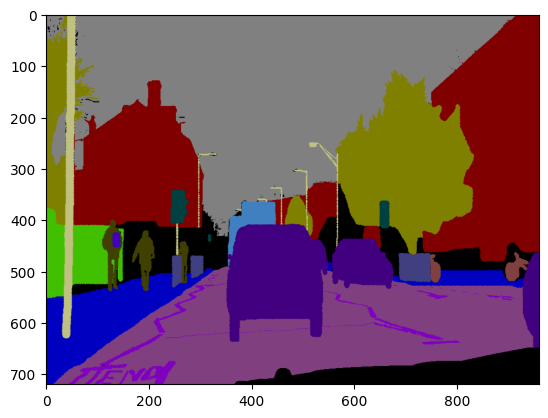

In [8]:
#---------------------Plot de imagens----------------------
plt.imshow(colors[pred_softmax].cpu())
#plt.imshow(test_data[0][0].permute(1, 2, 0).to(int))
plt.imshow(colors[train_data[0][1].to(int)].to(int).cpu())
train_data[0][1].unique(return_counts = True)

In [9]:
#--------------------Loops de treino e teste-------------
def loop_treino(dataloader, modelo, loss_fc, otimizador, epochs = 20):
    tamanho = len(dataloader.dataset)
    modelo.train()
    for epoch in range(epochs):
        loss_val = 0
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            # Calcula a previsão e a perda
            pred = modelo(X)
            loss = loss_fc(pred, y.to(int))

            # Retropropagação
            loss.backward()
            otimizador.step()
            otimizador.zero_grad()

        loss_val += loss.item()
        print(f"Epoch {epoch}: {loss_val:>7f}")


def loop_teste(dataloader, modelo, loss_fc):
    modelo.eval()

    tamanho = len(dataloader.dataset)
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = modelo(X)
            loss_test += loss_fc(pred, y).item()
            acertos += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss_test /= num_batches
    print(f"Erro no Teste: \n Perda média: {loss_test:>8f} \n")

In [10]:
#--------------Data loader, erro, otimizador, etc----------------------
batch_size = 2
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle = True)

optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

weights = classes["frequencies"].sum()/(classes["frequencies"] + 1e0)
error = nn.CrossEntropyLoss(weight = torch.Tensor(weights).to(device))


In [ ]:
loop_treino(train_dataloader, model, error, optimizer)

100%|██████████| 185/185 [03:44<00:00,  1.21s/it]


Epoch 0: 3.803414


100%|██████████| 185/185 [03:39<00:00,  1.19s/it]


Epoch 1: 3.259227


100%|██████████| 185/185 [03:38<00:00,  1.18s/it]


Epoch 2: 3.474323


 29%|██▊       | 53/185 [01:01<02:35,  1.18s/it]